# PCMark benchmark on Android

The goal of this experiment is to run benchmarks on a Pixel device running Android with an EAS kernel and collect results. The analysis phase will consist in comparing EAS with other schedulers, that is comparing *sched* governor with:

    - interactive
    - performance
    - powersave
    - ondemand
    
The benchmark we will be using is ***PCMark*** (https://www.futuremark.com/benchmarks/pcmark-android). You will need to **manually install** the app on the Android device in order to run this Notebook.

When opinening PCMark for the first time you will need to Install the work benchmark from inside the app.

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2017-08-08 14:43:53,365 INFO    : root         : Using LISA logging configuration:
2017-08-08 14:43:53,368 INFO    : root         :   /media/build/workspace/lisa-github/logging.conf


In [2]:
%pylab inline

import copy
import os
from time import sleep
from subprocess import Popen
import pandas as pd

# Support to access the remote target
import devlib
from env import TestEnv

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy

Populating the interactive namespace from numpy and matplotlib


## Test environment setup

For more details on this please check out **examples/utils/testenv_example.ipynb**.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in `my_target_conf`. Run `adb devices` on your host to get the ID. Also, you have to specify the path to your android sdk in ANDROID_HOME.

In [3]:
# Setup a target configuration
my_target_conf = {
    
#     # Target platform and board
#     "platform"    : 'android',

#     # Add target support
#     "board" : 'pixel',
    
#     # Device ID
#     "device" : "HT6670300102",
    
#     "ANDROID_HOME" : "/home/vagrant/lisa/tools/android-sdk-linux/",
    
    "platform"    : 'android',
    "board"       : "hikey960",
    "device" : "0123456789ABCDEF",
    
    "ANDROID_HOME" : "/media/build/workspace/android-sdk",
    # Define devlib modules to load
    "modules"     : [
        'cpufreq'       # enable CPUFreq support
    ],
}

In [4]:
my_tests_conf = {

    # Folder where all the results will be collected
    "results_dir" : "Android_PCMark",

    # Platform configurations to test
    "confs" : [
        {
            "tag"            : "pcmark",
            "flags"          : "ftrace",           # Enable FTrace events
            "sched_features" : "ENERGY_AWARE",     # enable EAS
        },
    ],
}

In [5]:
# Initialize a test environment using:
# the provided target configuration (my_target_conf)
# the provided test configuration   (my_test_conf)
te = TestEnv(target_conf=my_target_conf, test_conf=my_tests_conf)
target = te.target

2017-08-08 14:43:57,087 INFO    : TestEnv      : Using base path: /media/build/workspace/lisa-github
2017-08-08 14:43:57,090 INFO    : TestEnv      : Loading custom (inline) target configuration
2017-08-08 14:43:57,093 INFO    : TestEnv      : Loading custom (inline) test configuration
2017-08-08 14:43:57,094 WARNING : TestEnv      : Wipe previous contents of the results folder:
2017-08-08 14:43:57,094 WARNING : TestEnv      :    /media/build/workspace/lisa-github/results/Android_PCMark
2017-08-08 14:43:57,096 INFO    : TestEnv      : External tools using:
2017-08-08 14:43:57,100 INFO    : TestEnv      :    ANDROID_HOME: /media/build/workspace/android-sdk
2017-08-08 14:43:57,101 INFO    : TestEnv      :    CATAPULT_HOME: /media/build/workspace/lisa-github/tools/catapult
2017-08-08 14:43:57,102 INFO    : TestEnv      : Devlib modules to load: ['bl', 'cpuidle', 'cpufreq']
2017-08-08 14:43:57,104 INFO    : TestEnv      : Connecting Android target [0123456789ABCDEF]
2017-08-08 14:43:57,105

## Support Functions

This set of support functions will help us running the benchmark using different CPUFreq governors.

In [6]:
def set_performance():
    target.cpufreq.set_all_governors('performance')

def set_powersave():
    target.cpufreq.set_all_governors('powersave')

def set_interactive():
    target.cpufreq.set_all_governors('interactive')

def set_sched():
    target.cpufreq.set_all_governors('sched')

def set_ondemand():
    target.cpufreq.set_all_governors('ondemand')
    
    for cpu in target.list_online_cpus():
        tunables = target.cpufreq.get_governor_tunables(cpu)
        target.cpufreq.set_governor_tunables(
            cpu,
            'ondemand',
            **{'sampling_rate' : tunables['sampling_rate_min']}
        )

In [7]:
# CPUFreq configurations to test
confs = {
    'performance' : {
        'label' : 'prf',
        'set' :  set_performance,
    },
    #'powersave' : {
    #    'label' : 'pws',
    #    'set' :  set_powersave,
    #},
     'interactive' : {
         'label' : 'int',
         'set' :  set_interactive,
     },
    #'sched' : {
    #    'label' : 'sch',
    #    'set' :  set_sched,
    #},
    #'ondemand' : {
    #    'label' : 'odm',
    #    'set' :  set_ondemand,
    #}
}

# The set of results for each comparison test
results = {}

In [8]:
#Check if PCMark si available on the device

def check_packages(pkgname):
    try:
        output = target.execute('pm list packages -f | grep -i {}'.format(pkgname))
    except Exception:
        raise RuntimeError('Package: [{}] not availabe on target'.format(pkgname))

# Check for specified PKG name being available on target
check_packages('com.futuremark.pcmark.android.benchmark')

In [16]:
from android import Screen

target.execute('am force-stop {}'.format("com.futuremark.pcmark.android.benchmark"))
target.execute('input keyevent 82')
Screen.set_orientation(target, auto=False, portrait=True)
Screen.set_brightness(target, auto=False, percent=0)

# Start PCMark on the target device
target.execute('monkey --pct-syskeys 0 -p com.futuremark.pcmark.android.benchmark -c android.intent.category.LAUNCHER 1')
# Wait few seconds to make sure the app is loaded
Screen.set_orientation(target, auto=False, portrait=True)

# Wait few seconds to make sure the app is loaded
sleep(5)
    

# Run performance workload (assume screen is vertical)
target.execute('input tap 1205 515')

2017-08-08 15:15:38,659 INFO    : Screen       : Force manual orientation
2017-08-08 15:15:38,660 INFO    : Screen       : Set orientation: PORTRAIT
2017-08-08 15:15:40,071 INFO    : Screen       : Set brightness: 0%
2017-08-08 15:15:40,458 INFO    : Screen       : Force manual orientation
2017-08-08 15:15:40,460 INFO    : Screen       : Set orientation: PORTRAIT


''

In [17]:
# Function that helps run a PCMark experiment
from android import Screen

def pcmark_run(exp_dir):
    # Unlock device screen (assume no password required)
    target.execute('am force-stop {}'.format("com.futuremark.pcmark.android.benchmark"))
    target.execute('input keyevent 82')
    Screen.set_brightness(target, auto=False, percent=0)

    # Start PCMark on the target device
    target.execute('monkey --pct-syskeys 0 -p com.futuremark.pcmark.android.benchmark -c android.intent.category.LAUNCHER 1')
    Screen.set_orientation(target, auto=False, portrait=True)

    # Wait few seconds to make sure the app is loaded
    sleep(5)
    
    # Flush entire log
    target.clear_logcat()
    
    # Run performance workload (assume screen is vertical)
    target.execute('input tap 1205 515')
    # Wait for completion (10 minutes in total) and collect log
    log_file = os.path.join(exp_dir, 'log.txt')
    # Wait 5 minutes
    sleep(300)
    # Start collecting the log
    with open(log_file, 'w') as log:
        logcat = Popen(['adb logcat', 'com.futuremark.pcmandroid.VirtualMachineState:*', '*:S'],
                       stdout=log,
                       shell=True)
        # Wait additional two minutes for benchmark to complete
        sleep(300)

        # Terminate logcat
        logcat.kill()

    # Get scores from logcat
    score_file = os.path.join(exp_dir, 'score.txt')
    os.popen('grep -o "PCMA_.*_SCORE .*" {} | sed "s/ = / /g" | sort -u > {}'.format(log_file, score_file))
    
    # Close application
    target.execute('am force-stop com.futuremark.pcmark.android.benchmark')
    
    return score_file

In [18]:
# Function that helps run PCMark for different governors

def experiment(governor, exp_dir):
    os.system('mkdir -p {}'.format(exp_dir));

    logging.info('------------------------')
    logging.info('Run workload using %s governor', governor)
    confs[governor]['set']()

    ### Run the benchmark ###
    score_file = pcmark_run(exp_dir)
    
    # Save the score as a dictionary
    scores = dict()
    with open(score_file, 'r') as f:
        lines = f.readlines()
        for l in lines:
            info = l.split()
            scores.update({info[0] : float(info[1])})
    
    # return all the experiment data
    return {
        'dir'        : exp_dir,
        'scores'     : scores,
    }

## Run PCMark and collect scores

In [22]:
# Run the benchmark in all the configured governors
for governor in confs:
    test_dir = os.path.join(te.res_dir, governor)
    res = experiment(governor, test_dir)
    results[governor] = copy.deepcopy(res)
    print governor

2017-08-08 15:44:48,491 INFO    : root         : ------------------------
2017-08-08 15:44:48,493 INFO    : root         : Run workload using performance governor
2017-08-08 15:44:49,927 INFO    : Screen       : Set brightness: 0%
2017-08-08 15:44:50,701 INFO    : Screen       : Force manual orientation
2017-08-08 15:44:50,710 INFO    : Screen       : Set orientation: PORTRAIT
2017-08-08 15:54:57,572 INFO    : root         : ------------------------
2017-08-08 15:54:57,574 INFO    : root         : Run workload using interactive governor


performance


2017-08-08 15:54:58,947 INFO    : Screen       : Set brightness: 0%
2017-08-08 15:54:59,316 INFO    : Screen       : Force manual orientation
2017-08-08 15:54:59,318 INFO    : Screen       : Set orientation: PORTRAIT


interactive


After running the benchmark for the specified governors we can show and plot the scores:

In [23]:
# Create results DataFrame
data = {}
for governor in confs:
    data[governor] = {}
    for score_name, score in results[governor]['scores'].iteritems():
        data[governor][score_name] = score

df = pd.DataFrame.from_dict(data)
df

,interactive,performance
PCMA_DATA_MANIPULATION_SCORE,4927.993704,4327.702689
PCMA_PHOTO_EDITING_V2_SCORE,10091.627222,12798.990980
PCMA_VIDEO_EDITING_SCORE,0.000000,2466.405857
PCMA_WEB_V2_SCORE,6580.366379,7460.064285
PCMA_WORK_V2_SCORE,0.000000,5008.861976
PCMA_WRITING_V2_SCORE,4800.166543,3093.535179


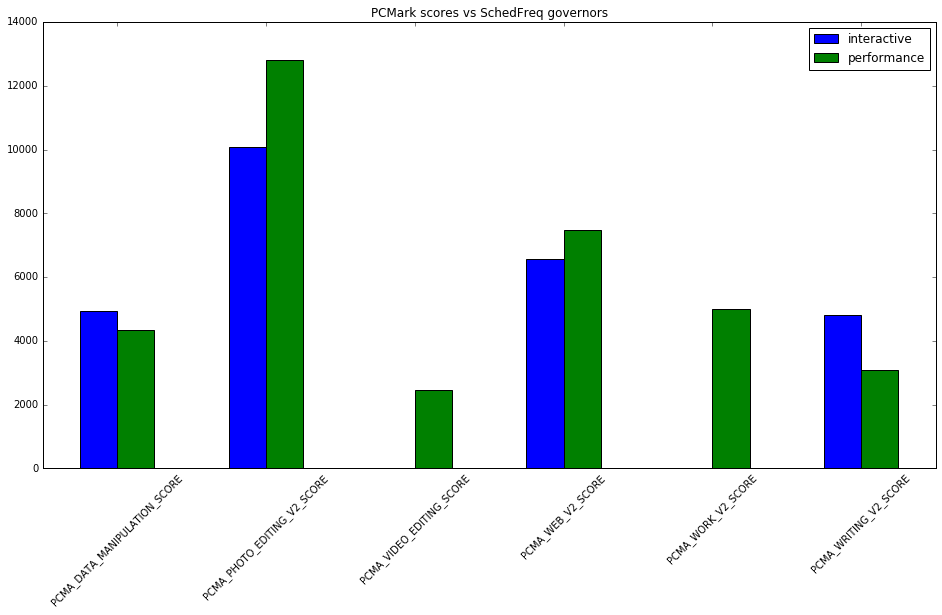

In [24]:
df.plot(kind='bar', rot=45, figsize=(16,8),
        title='PCMark scores vs SchedFreq governors');